In [4]:
# https://www.openml.org/apis

import math
import openml
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split



# AdaBoost com SMOTE p/ iteração

### SMOTE

In [5]:
def nearest_neighbour(X):
    nbs=NearestNeighbors(n_neighbors=5,metric='euclidean',algorithm='kd_tree').fit(X)
    euclidean,indices= nbs.kneighbors(X)
    return indices

def SMOTE(X, xs):
    indices2 = nearest_neighbour(X)
    matrix=[]

    for m in range(len(indices2)):
        t=xs[indices2[m]]
        newt=pd.DataFrame(t)
        matrix.append([])
        for j in range(len(newt.columns)):
            matrix[m].append(random.choice(newt[j]))
    return matrix

### AdaBoost

In [6]:
def purity(df, attribute):
    '''
    Calcula a pureza de um atributo em um dataframe.
    '''
    return df.groupby(attribute).size().max() / len(df)

    # Compute error rate, alpha and w
def compute_error(y, y_pred, w_i):
    '''
    2. b)
    Calcula o erro de um classificador fraco.
    '''
    return (sum(w_i * (np.not_equal(y, y_pred)).astype(int)))/sum(w_i)
def compute_alpha(error):
    '''
    2. c)
    Calculate o peso de um classificador fraco baseado no erro.
    '''
    return np.log((1 - error) / error)
def update_weights(w_i, alpha, y, y_pred):
    ''' 
    3.
    Recalcula os pesos de acordo com o erro e o peso do classificador fraco após cada iteração de boosting.
    '''  
    return w_i * np.exp(alpha * (np.not_equal(y, y_pred)).astype(int))

In [13]:
class AdaBoost:
    
    def __init__(self):
        self.alphas = []
        self.G_M = []
        self.M = None
        self.training_errors = []
        self.prediction_errors = []


    def fit(self, X, y, M = 100):
        '''
        Treina o modelo de boosting.
        '''
        self.alphas = [] 
        self.training_errors = []
        self.M = M

        # Itera por M iterações
        for m in range(0, M):
            
            unique, counts = np.unique(y, return_counts=True)
            minority_shape = dict(zip(unique, counts))[1]

            xs = np.ones((minority_shape, X.shape[1]))
            xs=[X[i] for i, v in enumerate(y) if v==1.0]
            xs=np.array(xs)

            sampled_instances = SMOTE(xs, xs)

            XSMOTE = np.concatenate((X,sampled_instances), axis = 0)

            y_sampled_instances = np.ones(minority_shape)
            ySMOTE = np.concatenate((y,y_sampled_instances), axis=0)

            # Define os pesos dos dados, se for a primeira iteração, todos os pesos são iguais
            if m == 0:
                w_i = np.ones(len(ySMOTE)) * 1 / len(ySMOTE)
            else:
                w_i = update_weights(w_i, alpha_m, ySMOTE, y_pred)
            
            # (a) Treinar o classificador fraco, é um stump com profundidade 1

            G_m = DecisionTreeClassifier(max_depth = 1, criterion= 'entropy', max_features= 1)
            G_m.fit(XSMOTE, ySMOTE, sample_weight = w_i)
            y_pred = G_m.predict(XSMOTE)
            
            self.G_M.append(G_m) # Guarda o classificador fraco numa lista

            # (b) Calcular o erro do classificador fraco
            error_m = compute_error(ySMOTE, y_pred, w_i)
            self.training_errors.append(error_m)

            # (c) Calcular o alpha do classificador fraco
            alpha_m = compute_alpha(error_m)
            self.alphas.append(alpha_m)
        
        
        assert len(self.G_M) == len(self.alphas)

    def predict(self, X):

        # Inicializo um dataframe para guardar as predições de cada classificador fraco
        weak_preds = pd.DataFrame(index = range(len(X)), columns = range(self.M)) 

        # Prevejo com cada classificador fraco e guardo no dataframe
        for m in range(self.M):
            y_pred_m = self.G_M[m].predict(X) * self.alphas[m]
            weak_preds.iloc[:,m] = y_pred_m

        # Calculo a escolha final (somo as predições de cada classificador fraco e verifico o sinal)
        y_pred = (1 * np.sign(weak_preds.T.sum())).astype(int)

        return y_pred
    
    def accuracy(self, y, y_pred):
        return sum(y == y_pred) / len(y)

# Dataset 1

In [8]:
# Importar o dataset

suite = openml.study.get_suite(99)

task_id = 37 # Supervised Classification on diabetes
task = openml.tasks.get_task(task_id)    

dataset = openml.datasets.get_dataset(task.dataset_id)

X, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="array", target=dataset.default_target_attribute
)

# Visualizar o dataset

df = pd.DataFrame(X, columns=attribute_names)
y = y * 2 - 1
df['target'] = y


<AxesSubplot:xlabel='target', ylabel='count'>

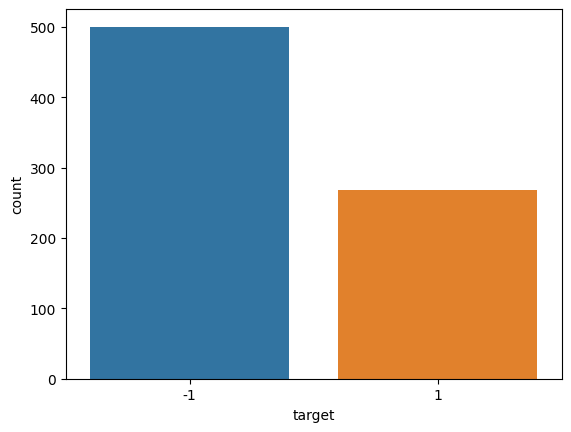

In [9]:
# Visualizar a distribuição das classes

sns.countplot(x='target', data=df)

## O nosso AdaBoost

In [14]:
X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, test_size=0.3, random_state=42)


ab = AdaBoost()
ab.fit(X_Train, y_Train)

y_pred = ab.predict(X_Test)

Accuracy:  0.7142857142857143


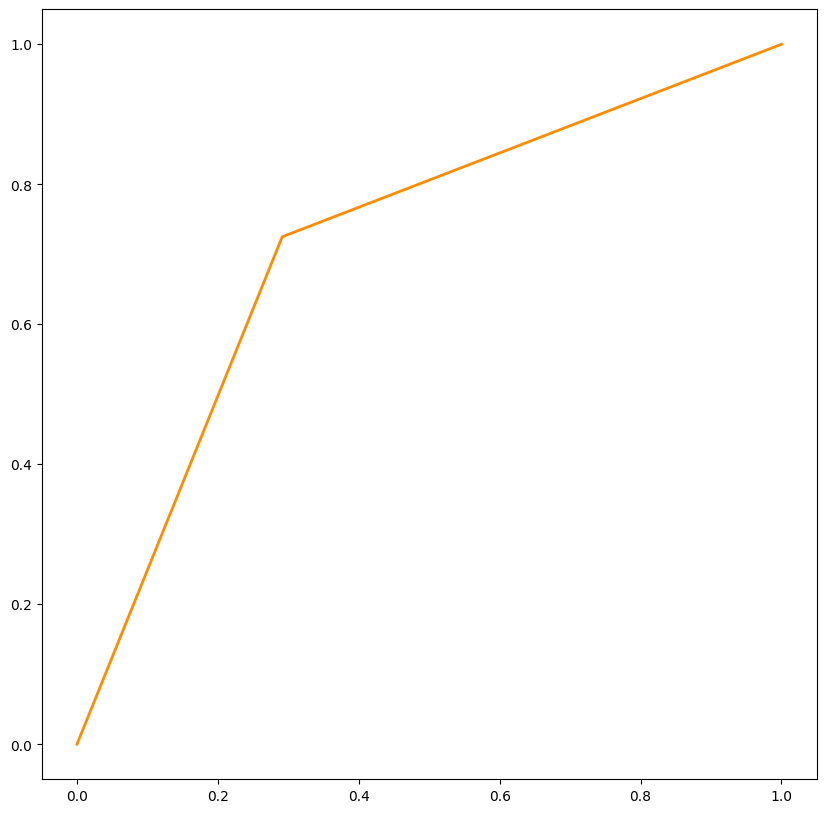

AUC:  0.7168046357615895


In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_Test, y_pred)

print('Accuracy: ', ab.accuracy(y_Test, y_pred))

# ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_Test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.show()

print('AUC: ', roc_auc)

## AdaBoost Default

0.7142857142857143


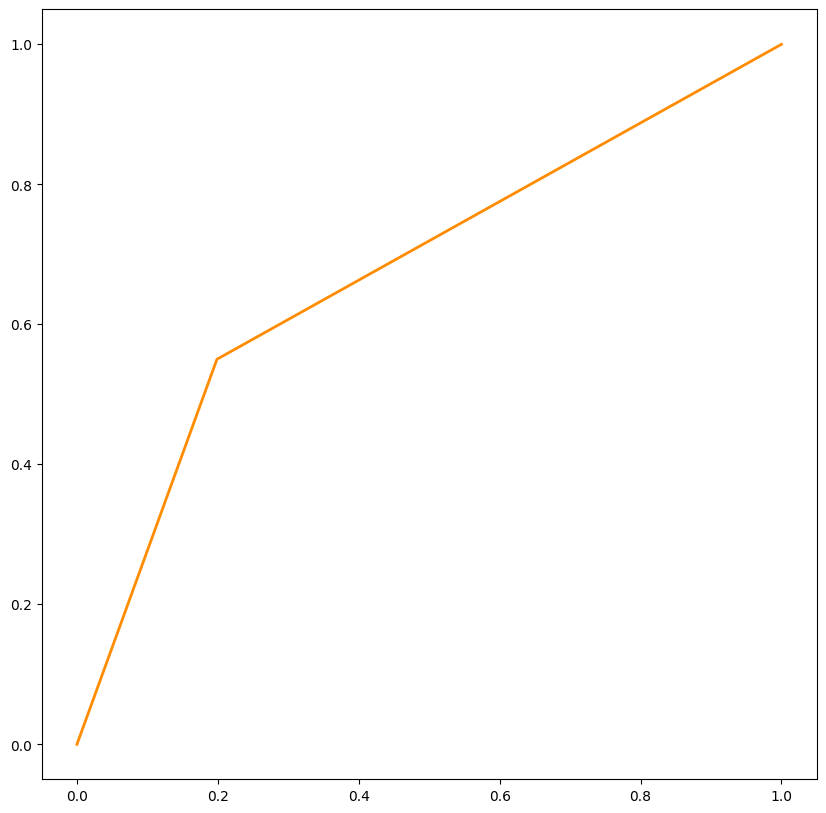

AUC:  0.6756622516556291


In [17]:
from sklearn.ensemble import AdaBoostClassifier

ab = AdaBoostClassifier(n_estimators = 200)
ab.fit(X_Train, y_Train)
print(ab.score(X_Test, y_Test))

y_predsk = ab.predict(X_Test)
fpr, tpr, thresholds = roc_curve(y_Test, y_predsk)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.show()

print('AUC: ', roc_auc)

### Tabelas de Contigência

##### Nosso

<AxesSubplot:>

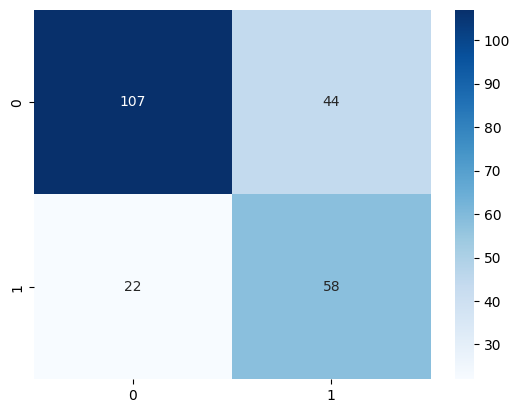

In [18]:
sns.heatmap(confusion_matrix(y_Test, y_pred), annot=True, fmt='d', cmap='Blues')

##### Sklearn

<AxesSubplot:>

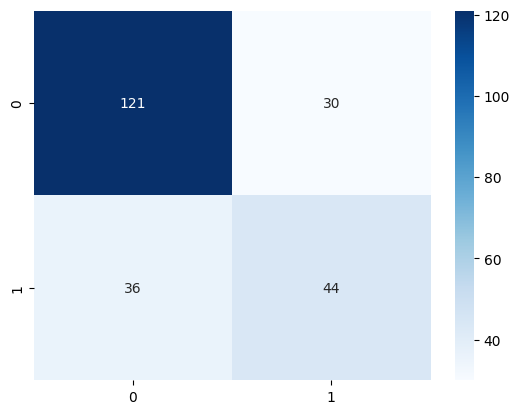

In [19]:
sns.heatmap(confusion_matrix(y_Test, y_predsk), annot=True, fmt='d', cmap='Blues')

In [20]:
# calculate precision and recall on both models
from sklearn.metrics import precision_score, recall_score

print('Precision Nosso: ', precision_score(y_Test, y_pred))
print('Recall Nosso: ', recall_score(y_Test, y_pred))

print('Precision Sklearn: ', precision_score(y_Test, y_predsk))
print('Recall Sklearn: ', recall_score(y_Test, y_predsk))

Precision Nosso:  0.5686274509803921
Recall Nosso:  0.725
Precision Sklearn:  0.5945945945945946
Recall Sklearn:  0.55


# Dataset 2

In [21]:
# Importar o dataset

task_id = 9914 # Supervised Classification on kr-vs-kp
task = openml.tasks.get_task(task_id)    
dataset = openml.datasets.get_dataset(task.dataset_id)
X2, y2, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="array", target=dataset.default_target_attribute
)

# Visualizar o dataset
df2 = pd.DataFrame(X2, columns=attribute_names)
y2 = y2 * 2 - 1

df2['target'] = y2

<AxesSubplot:xlabel='target', ylabel='count'>

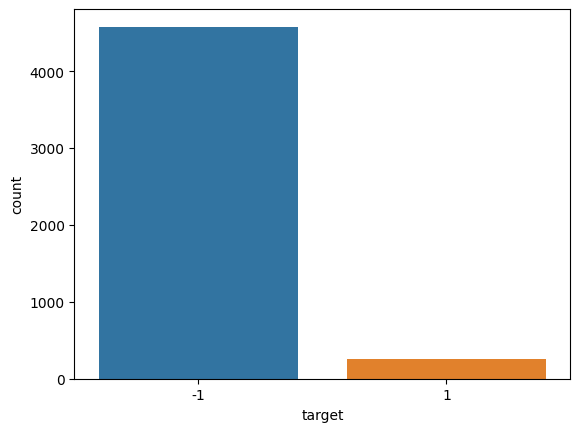

In [22]:
# Visualizar a distribuição das classes

sns.countplot(x='target', data=df2)

In [23]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

ab2 = AdaBoost()
ab2.fit(X2_train, y2_train)

y2_predSMOTE = ab2.predict(X2_test)

Accuracy:  0.9696969696969697


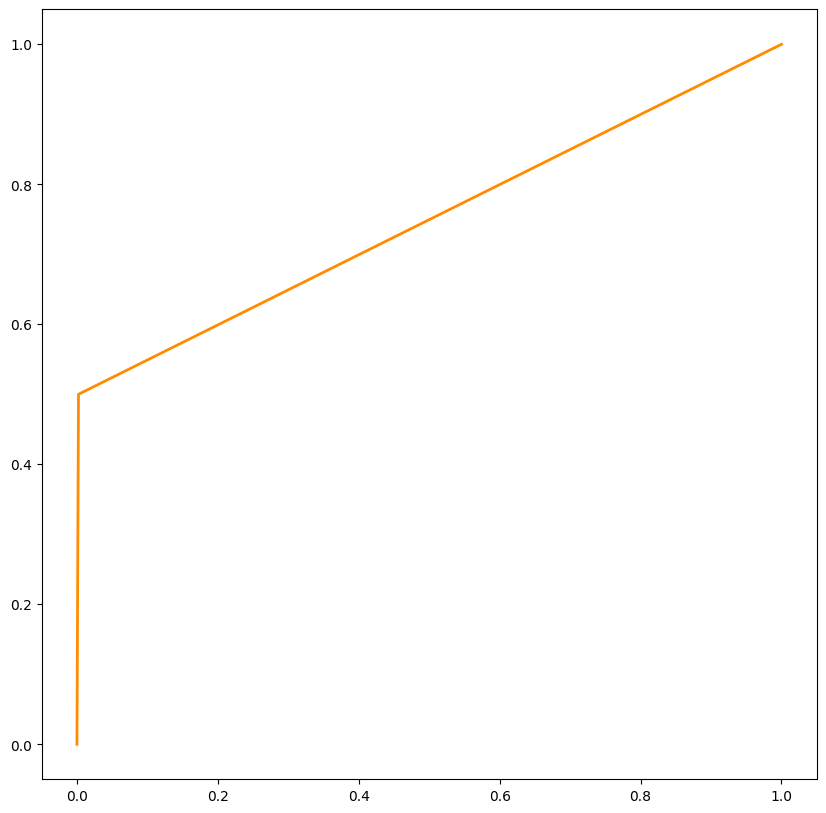

AUC:  0.7489051094890511


In [24]:
# analyse results on the prediction

print('Accuracy: ', ab2.accuracy(y2_test, y2_predSMOTE))

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y2_test, y2_predSMOTE)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.show()

print('AUC: ', roc_auc)

### Vamos comparar com o AdaBoost do sklearn

0.9758953168044077


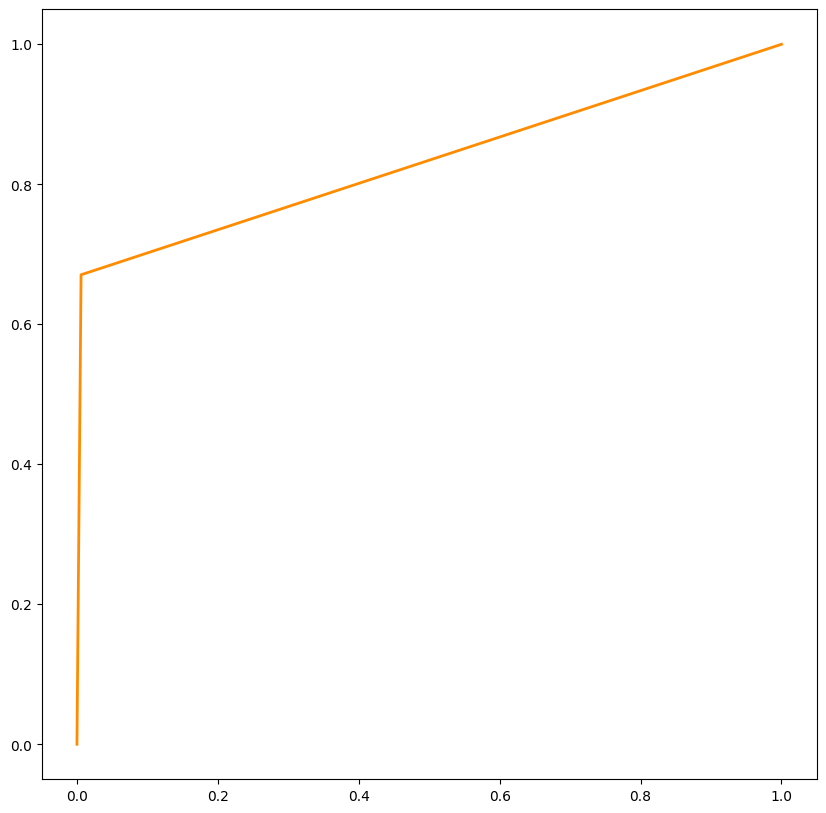

AUC:  0.8324461456293396


In [25]:
ab2sk = AdaBoostClassifier(n_estimators = 100)
ab2sk.fit(X2_train, y2_train)
print(ab2sk.score(X2_test, y2_test))


y2_pred2 = ab2sk.predict(X2_test)

fpr, tpr, thresholds = roc_curve(y2_test, y2_pred2)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.show()

print('AUC: ', roc_auc)

### Tabelas de Contigência

##### Nosso

<AxesSubplot:>

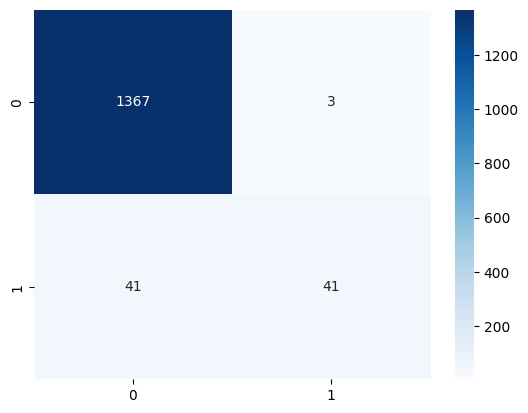

In [26]:
sns.heatmap(confusion_matrix(y2_test, y2_predSMOTE), annot=True, fmt='d', cmap='Blues')### 

##### Sklearn

<AxesSubplot:>

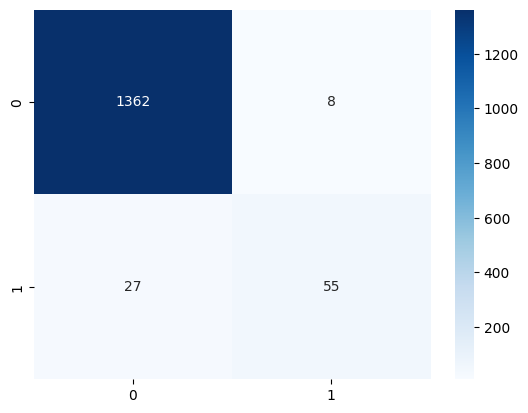

In [27]:
sns.heatmap(confusion_matrix(y2_test, y2_pred2), annot=True, fmt='d', cmap='Blues')

### Precision and Recall

In [28]:
from sklearn.metrics import precision_score, recall_score

print('Precision Nosso: ', precision_score(y2_test, y2_predSMOTE))
print('Recall Nosso: ', recall_score(y2_test, y2_predSMOTE))

print('Precision Sklearn: ', precision_score(y2_test, y2_pred2))
print('Recall Sklearn: ', recall_score(y2_test, y2_pred2))

Precision Nosso:  0.9318181818181818
Recall Nosso:  0.5
Precision Sklearn:  0.873015873015873
Recall Sklearn:  0.6707317073170732


## Dataset 3

In [29]:
# Importar o dataset

task_id = 3896 # Supervised Classification on ada_agnostic
task = openml.tasks.get_task(task_id)    
dataset = openml.datasets.get_dataset(task.dataset_id)
X3, y3, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="array", target=dataset.default_target_attribute
)
df3 = pd.DataFrame(X3, columns=attribute_names)
y3 = y3 * 2 - 1
df3['target'] = y3

<AxesSubplot:xlabel='target', ylabel='count'>

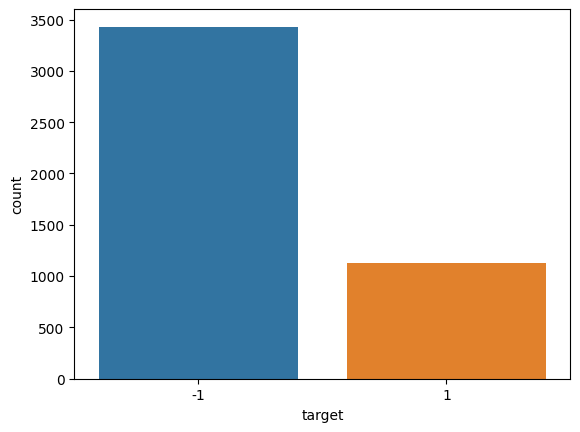

In [30]:
# Visualizar a distribuição das classes

sns.countplot(x='target', data=df3) # nice

## O nosso AdaBoost

In [31]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=42)

# Fit model
ab2 = AdaBoost()
ab2.fit(X3_train, y3_train)

# Predict on test set
y3_pred = ab2.predict(X3_test)

# é normal demorar uns 2 min

Accuracy:  0.7647918188458729


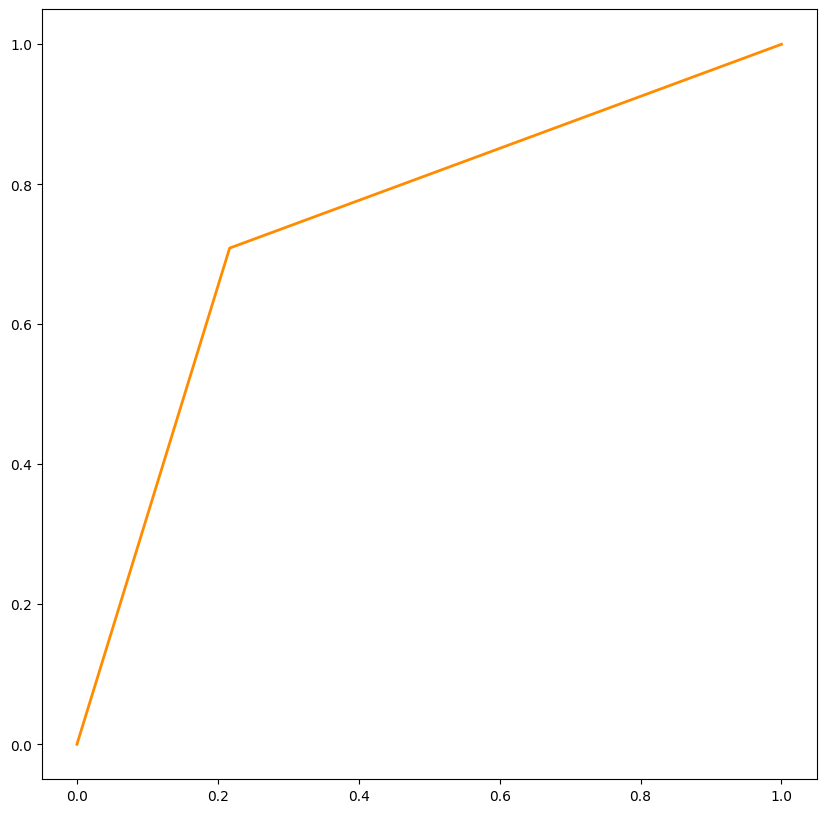

AUC:  0.7460541359400904


In [32]:
# Accuracy
print('Accuracy: ', ab2.accuracy(y3_test, y3_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y3_test, y3_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.show()

print('AUC: ', roc_auc)

## AdaBoost Default

Accuracy:  0.843681519357195


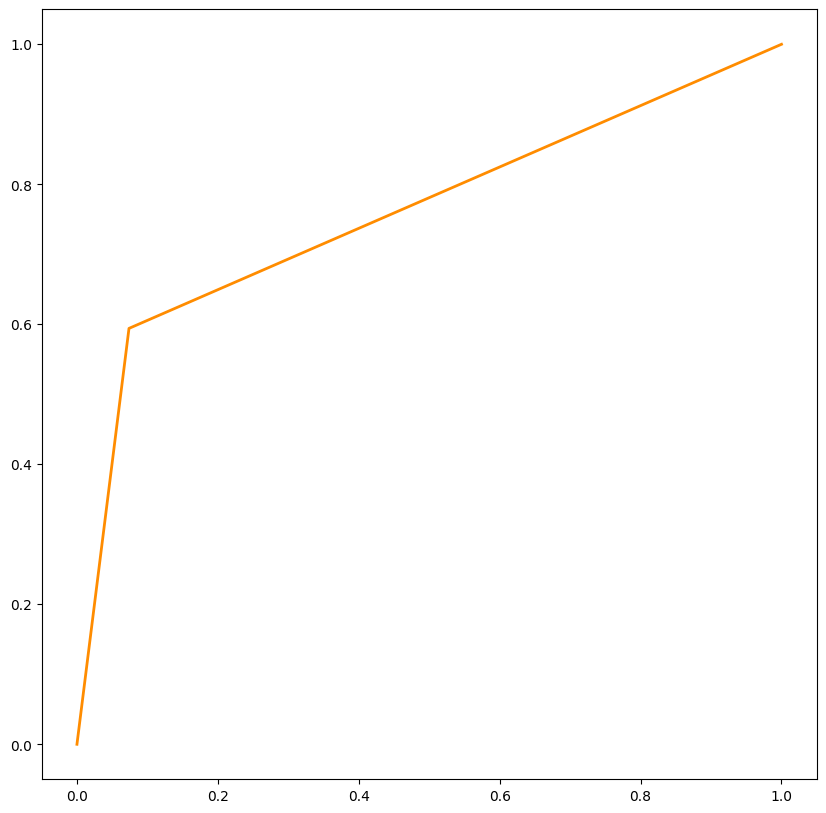

AUC:  0.7601297661921911


In [33]:
ab3sk = AdaBoostClassifier(n_estimators = 100)
ab3sk.fit(X3_train, y3_train)
print("Accuracy: ", (ab3sk.score(X3_test, y3_test)))

y3_pred2 = ab3sk.predict(X3_test)
fpr, tpr, thresholds = roc_curve(y3_test, y3_pred2)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.show()

print('AUC: ', roc_auc)

### Tabelas de Contigência

##### Nosso

<AxesSubplot:>

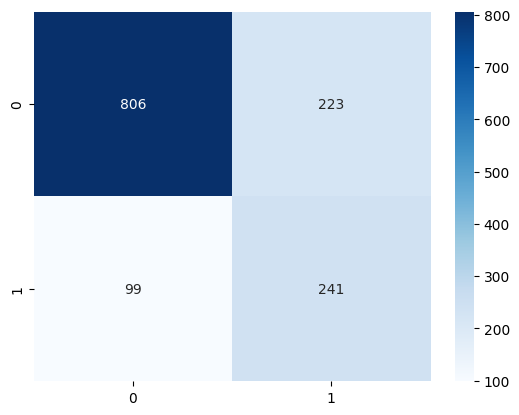

In [34]:
sns.heatmap(confusion_matrix(y3_test, y3_pred), annot=True, fmt='d', cmap='Blues')

##### Sklearn

<AxesSubplot:>

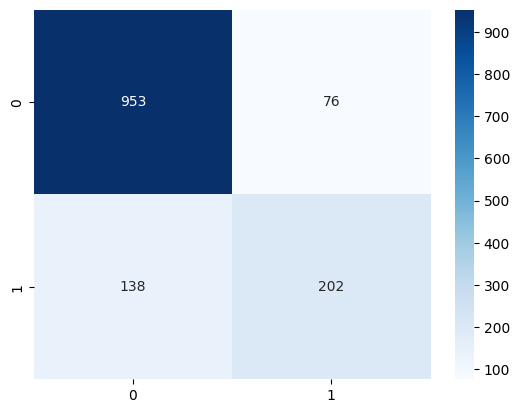

In [35]:
sns.heatmap(confusion_matrix(y3_test, y3_pred2), annot=True, fmt='d', cmap='Blues')

### Precision and Recall

In [36]:
print('Precision Nosso: ', precision_score(y3_test, y3_pred))
print('Recall Nosso: ', recall_score(y3_test, y3_pred))

print('Precision Sklearn: ', precision_score(y3_test, y3_pred2))
print('Recall Sklearn: ', recall_score(y3_test, y3_pred2))

Precision Nosso:  0.5193965517241379
Recall Nosso:  0.7088235294117647
Precision Sklearn:  0.7266187050359713
Recall Sklearn:  0.5941176470588235
